Author: Elli Heyes (elli.heyes@city.ac.uk)
Last edited: 10/06/2024

In this notebook we construct a reinforcement learning algorithm to generate FRST triangulations of reflexive polytopes.
We use a deep Q-learning algorithm, where the triangulation states are encoded by 2-face triangulations. 

In [2]:
import sys
import subprocess
try:
    import keras 
    import tensorflow as tf
except:
    subprocess.check_call([sys.executable, '-m', 'pip', 'install', 'tensorflow'])
    subprocess.check_call([sys.executable, '-m', 'pip', 'install', 'keras'])
    import keras
    import tensorflow as tf
import random
import numpy as np
import matplotlib.pyplot as plt
from copy import deepcopy
from collections import deque
from cytools import Polytope
from cytools import fetch_polytopes
from utils import get_two_face_triangs, get_T_actions, random_T_state, T_fitness, T_act

In [3]:
def agent(state_shape, action_shape):
    """ The agent maps X-states to Y-actions."""
    learning_rate = 0.001
    my_optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
    my_loss = tf.keras.losses.MeanSquaredError()
    my_metric = tf.keras.metrics.MeanAbsoluteError() 
    
    model = keras.Sequential()
    model.add(keras.layers.Dense(100, input_shape=state_shape, activation='relu'))
    model.add(keras.layers.Dense(200, activation='relu'))
    model.add(keras.layers.Dense(action_shape, activation='linear'))
    model.compile(loss=my_loss, optimizer=my_optimizer, metrics=[my_metric])
    return model

In [4]:
def train(replay_memory, model, target_model):
    learning_rate = 0.7 
    discount_factor = 0.618

    min_replay_size = 1000
    if len(replay_memory)<min_replay_size:
        return
    
    batch_size = 256
    mini_batch = random.sample(replay_memory, batch_size)
    current_states = np.array([np.array(transition[0]).flatten() for transition in mini_batch])
    current_qs_list = model.predict(current_states, verbose=0)
    new_current_states = np.array([np.array(transition[3]).flatten() for transition in mini_batch])
    future_qs_list = target_model.predict(new_current_states, verbose=0)

    X, Y = [], []
    for index, (state, action, reward, new_state, terminated) in enumerate(mini_batch):
        if not terminated:
            max_future_q = reward+discount_factor*np.max(future_qs_list[index])
        else:
            max_future_q = reward

        current_qs = current_qs_list[index]
        current_qs[action] = (1-learning_rate)*current_qs[action]+learning_rate*max_future_q

        X.append(np.array(state).flatten())
        Y.append(current_qs)

    model.fit(np.array(X), np.array(Y), batch_size=batch_size, verbose=0, shuffle=True)

In [7]:
# set the netowrk hyperparameters
max_epsilon = 1 # you can't explore more than 100% of the time
min_epsilon = 0.01 # at a minimum, we'll always explore 1% of the time
decay = 0.01

In [8]:
# initialise the polytope
all_polys = fetch_polytopes(h11=15, lattice="N", as_list=True, limit=100)
p = all_polys[0]

# get the list of all 2-face triangulations 
two_face_triangs = get_two_face_triangs(p)

# get the maximum number of triangulations for a 2-face
max_num_triangs = max(len(x) for x in two_face_triangs)
print(max_num_triangs)

# get the action list 
action_list = get_T_actions(two_face_triangs)  
print(len(action_list))

5
20


In [10]:
# pre-training test
terminal_states, pre_train_count, pre_train_steps = [], [], []
finished = False
while not finished:
    # initialise step count
    step = 1
    
    # randomly set the initial state
    state = random_T_state(two_face_triangs, max_num_triangs)
 
    # compute the fitness of the initial state 
    fitness = T_fitness(p, two_face_triangs, state)
    
    # check if already terminal 
    if fitness == 1:
        terminated = True
        pre_train_steps.append(step)
        
        #  check if new state already exists in the list and if not add it
        if not state in terminal_states:
            terminal_states.append(state)
        
        # update count list
        pre_train_count.append(len(terminal_states))
    
        # if no new FRSTs are found in the last 1000 runs then finish
        if len(pre_train_count) > 1000:
            if len(set(pre_train_count[-1000:])) == 1:
                finished = True
        
    else:  
        terminated = False
    
    # if not immediately terminal, continue until terminated
    while not terminated:
        # update step number
        step += 1
            
        # randomly sample an action from the action space
        action = random.choice(range(len(action_list)))
        
        # define the next state from the action
        new_state = T_act(state, action_list[action])

        # check if the next state is FRST 
        fitness = T_fitness(p, two_face_triangs, new_state)
        if fitness == 1:
            terminated = True
            pre_train_steps.append(step)
            
            #  check if new state already exists in the list and if not add it
            if not new_state in terminal_states:
                terminal_states.append(new_state)

            # update count list
            pre_train_count.append(len(terminal_states))
            
            # if no new FRSTs are found in the last 1000 runs then finish
            if len(pre_train_count) > 1000:
                if len(set(pre_train_count[-1000:])) == 1:
                    finished = True
            
        # update the state
        state = deepcopy(new_state)

print("Pre-Training Average # Steps: ",np.mean(pre_train_steps))

Pre-Training Average # Steps:  3.296947004608295


In [11]:
# set the netowrk hyperparameters
max_epsilon = 1 # you can't explore more than 100% of the time
min_epsilon = 0.01 # at a minimum, we'll always explore 1% of the time
decay = 0.01

# set the network input and output sizes
state_shape =  (len(p.faces(2))*max_num_triangs,)
action_shape = len(action_list)

# initialise the main model (updated every 4 runs)
model = agent(state_shape, action_shape)

# initialise the target model (updated every 100 runs)
target_model = agent(state_shape, action_shape)
target_model.set_weights(model.get_weights())

# initialise memory
replay_memory = deque(maxlen=50_000)

# epsilon-greedy algorithm in initialized at 1 meaning every step is random at the start
epsilon = 1

/home/cytools/cytools-venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [12]:
# train the deep Q-learning network for 1000 episodes
steps_to_update_model = 0
for episode in range(1000):   
    if episode % 100 == 0:
        print(episode/1000)
        
    # randomly set the initial state
    state = random_T_state(two_face_triangs, max_num_triangs)
    
    # compute the fitness of the initial state 
    fitness = T_fitness(p, two_face_triangs, state)
    
    # check if initial state is already terminal 
    if fitness == 1:
        terminated = True
        steps_to_update_model += 1
        replay_memory.append([state, 0, 10, state, terminated])
    else:  
        terminated = False
    
    # if initial state is not immediately terminal, continue until terminated
    while not terminated:
        # randomly sample a number from 0 to 1 
        # if number is less than epsilon then explore the action space
        # else exploit the learned values
        if random.uniform(0,1)<epsilon:
            # randomly sample an action from the action space
            action = random.choice(range(len(action_list)))
        else:
            # choose action with the highest predicted q value
            encoded = np.array(state).flatten()
            encoded_reshaped = encoded.reshape([1, encoded.shape[0]])
            predicted = model.predict(encoded_reshaped, verbose=0).flatten()
            action = np.argmax(predicted)

        # define the next state from the action
        new_state = T_act(state, action_list[action])
        
        # compute the fitness of the next state 
        fitness = T_fitness(p, two_face_triangs, new_state)
        
        # if the new state is FRST then assign a big reward and update the terminated variable
        if fitness == 1:
            reward = 10
            terminated = True
            steps_to_update_model += 1
        else:
            # if the new state is not FRST then compute the reward using the reward function
            reward = T_fitness(p, two_face_triangs, new_state) - T_fitness(p, two_face_triangs, state)  
        
        # update the replay memory 
        replay_memory.append([state, action, reward, new_state, terminated])
        
        # update the state
        state = deepcopy(new_state)
    
    # update the models
    if steps_to_update_model % 4 == 0:
        train(replay_memory, model, target_model)
    
    if steps_to_update_model == 100:
        target_model.set_weights(model.get_weights())
        steps_to_update_model = 0
    
    # update epsilon parameter
    epsilon = min_epsilon+(max_epsilon-min_epsilon)*np.exp(-decay*episode)   

0.0
0.1
0.2
0.3
0.4
0.5
0.6
0.7
0.8
0.9


In [13]:
# post-training test
terminal_states, post_train_count, post_train_steps = [], [], []
finished = False
while not finished:
    # initialise step count 
    step = 1
    
    # randomly set the initial state
    state = random_T_state(two_face_triangs, max_num_triangs)
    
    # compute the fitness of the initial state 
    fitness = T_fitness(p, two_face_triangs, state)
    
    # check if initial state is already terminal 
    if fitness == 1:
        terminated = True
        post_train_steps.append(step)
        
        #  check if new state already exists in the list and if not add it
        if not state in terminal_states:
            terminal_states.append(state)
        
        # update count list
        post_train_count.append(len(terminal_states))
    
        # if no new FRSTs are found in the last 1000 runs then finish
        if len(post_train_count) > 1000:
            if len(set(post_train_count[-1000:])) == 1:
                finished = True
    else:
        terminated = False
    
    # if initial state is not immediately terminal, continue until terminated
    path = []
    while not terminated:
        # append the path with the current state
        path.append(state)
        
        # choose the next state as the one with the highest q value that hasn't been visited before
        new = False
        encoded = np.array(state).flatten()
        encoded_reshaped = encoded.reshape([1, encoded.shape[0]])
        q_list = target_model.predict(encoded_reshaped, verbose=0).flatten()

        while not new:
            # update step number
            step += 1
            
            # choose action with the highest predicted q value
            action = np.argmax(q_list)

            # define the next state from the action
            new_state = T_act(state, action_list[action])
            
            # check if the next state has been visited before
            if new_state not in path:
                new = True
            
            # update the q value of the next state in the q list
            q_list[np.argmax(q_list)] = -100
            
        # check if the next state is FRST  
        fitness = T_fitness(p, two_face_triangs, new_state)
        if fitness == 1:
            terminated = True
            post_train_steps.append(step)
            
            # check if new state is already in the list and if not add it
            if not new_state in terminal_states:
                terminal_states.append(new_state)
            
            # update count list
            post_train_count.append(len(terminal_states))
            
            # if no new FRSTs are found in the last 1000 runs then finish
            if len(post_train_count) > 1000:
                if len(set(post_train_count[-1000:])) == 1:
                    finished = True
                
        # update the state
        state = deepcopy(new_state)
        
print("Post-Training Average # Steps: ",np.mean(post_train_steps))

Post-Training Average # Steps:  1.4165912518853696


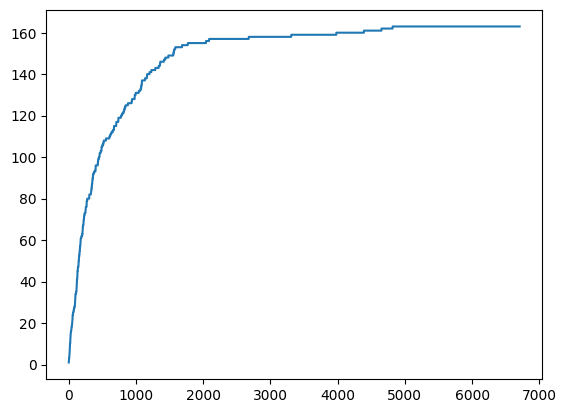

In [18]:
pre_train_total_steps = [pre_train_steps[0]]
for i in range(1,len(steps)):
    pre_train_total_steps.append(pre_train_total_steps[i-1]+pre_train_steps[i])
    
post_train_total_steps = [post_train_steps[0]]
for i in range(1,len(steps2)):
    post_train_total_steps.append(post_train_total_steps[i-1]+post_train_steps[i])

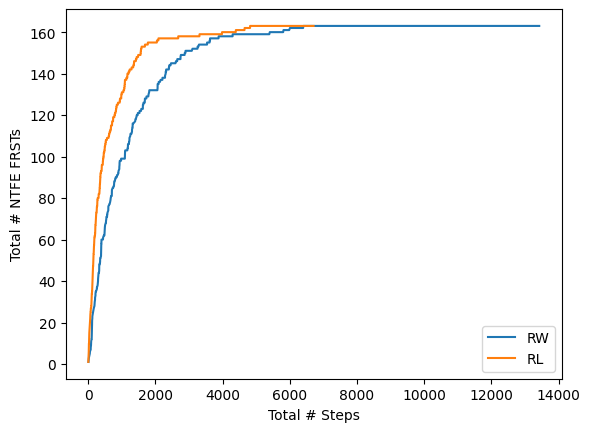

In [19]:
plt.plot(pre_train_total_steps, pre_train_count, label="RW")
plt.plot(pre_train_total_steps, post_train_count, label="RL")
plt.xlabel('Total # Steps')
plt.ylabel('Total # NTFE FRSTs')
plt.legend()
plt.savefig('Example_RL_v_RW')